In [1]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(pdftools)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



In [2]:
sinfo_path = "../../output/sims_info.tsv"
sinfoh_path = "../../output/header_sims_info.tsv"

In [3]:
win_size = 1000000
chroms= c("chr12")
win_len = -1
padding = 0
rescf = 1
prop_acc=0.4

In [31]:
fig_prefixes = c("cor-pidxy-dT", "subset-chr12-landscapes","annot-correls-tmrca")
fig_prefixes = c("annot-correls-tmrca")

In [5]:
sims_path = "../../output/sims_results/"
varmut_sims_path = "../../output/varmut/sims_results/"

In [6]:
# loading sims info table
sinfo = read.table(sinfo_path, sep="\t")
h = read.table(sinfoh_path, sep="\t", header=TRUE)
cnames = colnames(h)
if (length(sinfo) == length(h)+1) {
    cnames = c(cnames, "poscoefdecayeps")
}
colnames(sinfo) = cnames

In [7]:
#diff_cols = c("delrate","delcoef","posrate","poscoef","mu", "rescf", "win_len", "padding", "chr")
diff_cols = c("delrate","delcoef","posrate","poscoef","mu", "poscoefdecayeps", "rescf", "win_len", "padding", "chr")

In [8]:
wsize_str = paste0("win-size_",as.integer(win_size))

In [9]:
sims_folders = paste0(sims_path,list.files(sims_path)[grep(wsize_str, list.files(sims_path))])

In [10]:
varmut_sims_folders = paste0(varmut_sims_path,list.files(varmut_sims_path)[grep(wsize_str, list.files(varmut_sims_path))])

In [11]:
sims_folders = c(sims_folders, varmut_sims_folders)

In [12]:
simresults = as.data.frame(do.call(rbind, lapply(X = sims_folders, function(x) unlist(meta_from_fname(x,prop=prop_acc,suffix="$")))), stringsAsFactors =FALSE)

[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"


In [13]:
#sims_folders

In [14]:
simresults$folderpath = sims_folders

In [15]:
tmp = unique(sinfo[sinfo$sup_rand_id %in% simresults$sup_rand_id,c(diff_cols,"sup_rand_id")])

In [16]:
#sinfo[sinfo$sup_rand_id=="O814WK8MN3UOF27JIR",]["rand_id"]

In [17]:
simresults = left_join(simresults, tmp)

Joining, by = "sup_rand_id"



In [18]:
simresults = simresults[simresults$win_len==win_len & simresults$padding == padding & simresults$rescf==1 & as.numeric(simresults$win_size) == win_size & simresults$chr %in% chroms,]

In [19]:
simresults[is.na(simresults$poscoefdecayeps),]$poscoefdecayeps = 0

In [20]:
simresults$selregime = ifelse(simresults$posrate<1e-16,ifelse(simresults$delrate<1e-16, ifelse(simresults$sigma==0, "neutral", "varmut"), "del_only"), ifelse(simresults$delrate<1e-16, "pos_only", "both"))

In [21]:
simresults$seldesc = apply(
    simresults,
    1,
    function(x) paste("mu-D=", x["delrate"],
                      " mu-B=", x["posrate"],
                      ifelse(x['selregime'] %in% c("del_only", "both"), paste0("\ncoef-D=", x["delcoef"]), ""),
                      ifelse(x['selregime'] %in% c("both", "pos_only"), paste0("\ncoef-B=", x["poscoef"], " decay-B=", x["poscoefdecayeps"]), ""),
                      ifelse(x["selregime"]=="varmut", paste0(" mut-sd=", x['sigma']),""),
                      "\n(", x["sup_rand_id"], ")", 
                      sep=""))

In [22]:
simresults$sigma = as.numeric(simresults$sigma)

In [69]:
tmp = simresults
ordered = c("neutral", "del_only", "pos_only", "both", "varmut")
classes = unique(tmp$selregime)
tmp$selregime = factor(tmp$selregime, levels=classes[order(match(classes,ordered))])
tmp = tmp[
  with(tmp, order(selregime,posrate,-poscoefdecayeps,delrate,poscoef,delcoef,sigma)),
]

In [96]:
tmp = tmp[1:2,]

In [97]:
rownames(tmp) <- NULL
tab=table(tmp$selregime)
tab = c("data"=1, tab)
areas = list()
row = 1
for (regime in names(tab)) {
    col = 1
    for(i in 1:tab[regime]) {
        areas = c(areas, list(area(row,col)))
        col = col + 1
    }
    row = row + 1
}

areas = (do.call(c, areas))

In [98]:
    plots = apply(tmp,1,
                  function(x) readRDS(paste0(x["folderpath"],
                                             "/",fig_prefixes[1], "_",x["desc"],".rds"))+labs(subtitle=x["seldesc"])+theme(legend.position="none"))

    data_path = paste0("../../output/greatapes-diversity-data/",fig_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_prop-acc_",prop_acc, ".rds")
    plots=c(list(readRDS(data_path)+labs(subtitle="data")), plots)


In [99]:
length(plots)

[1] 3

In [110]:
plots[[2]]$guides = NULL

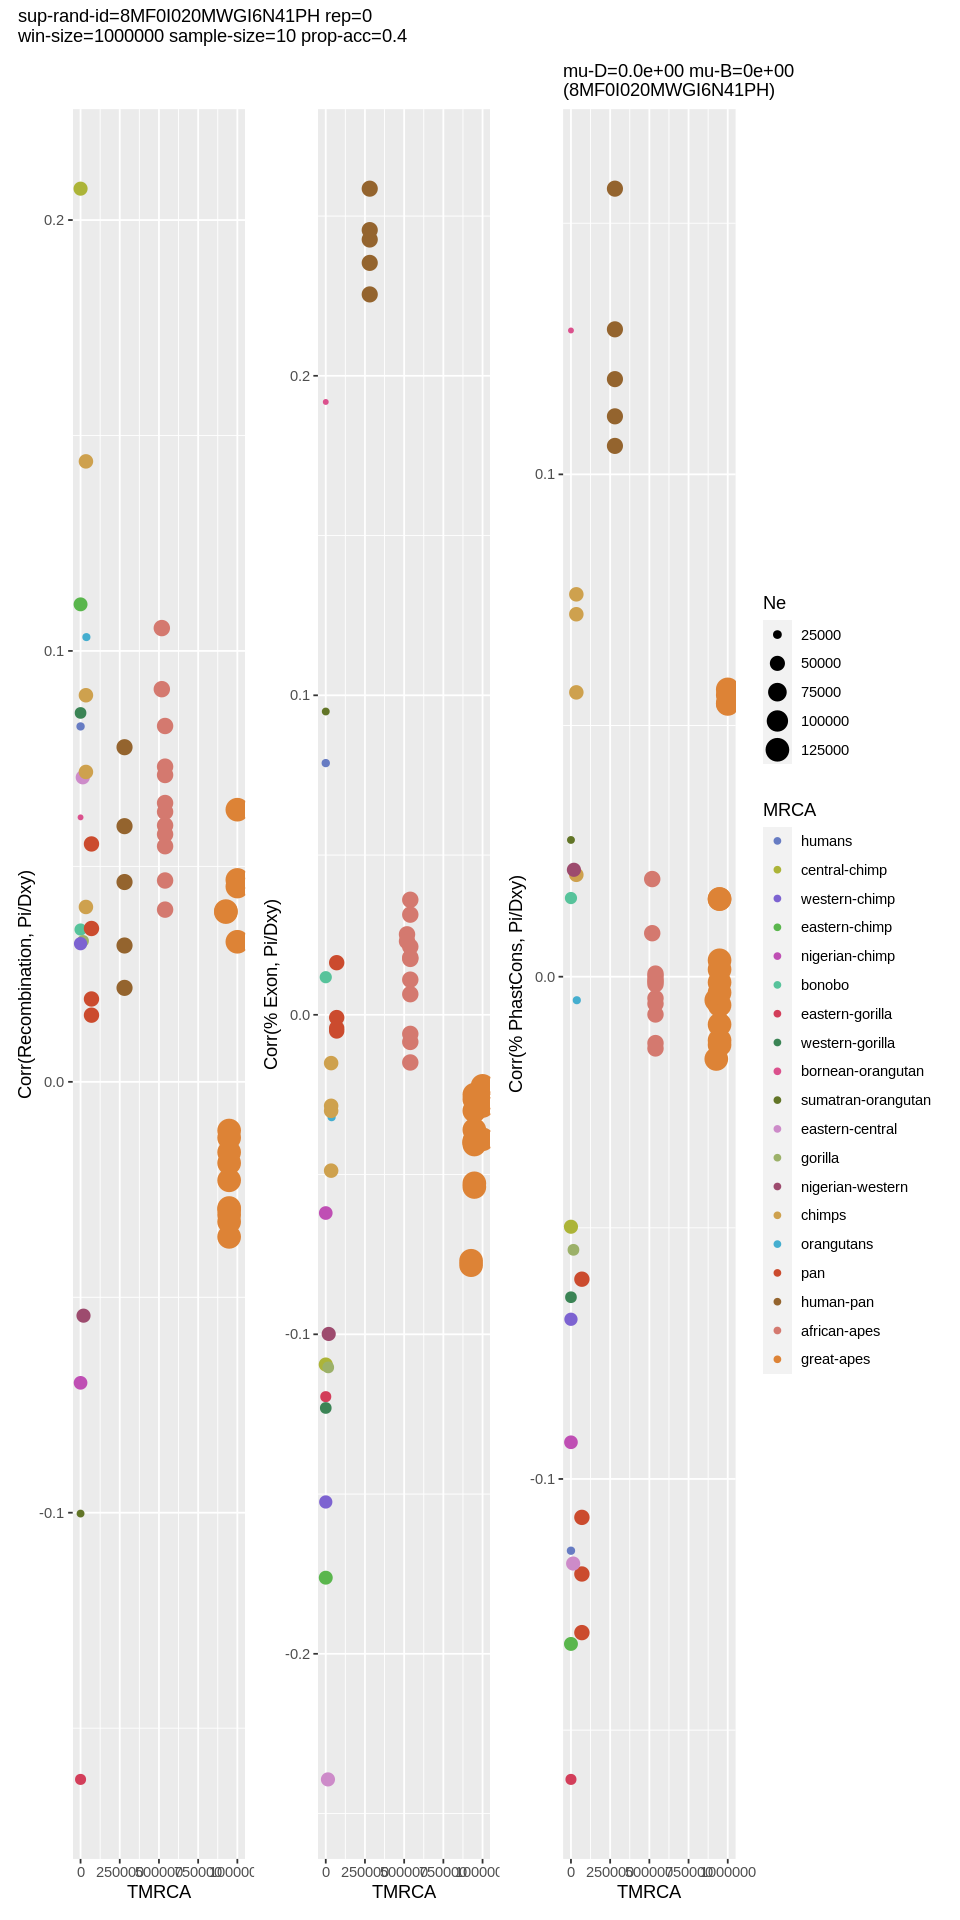

In [111]:
plots[[2]]

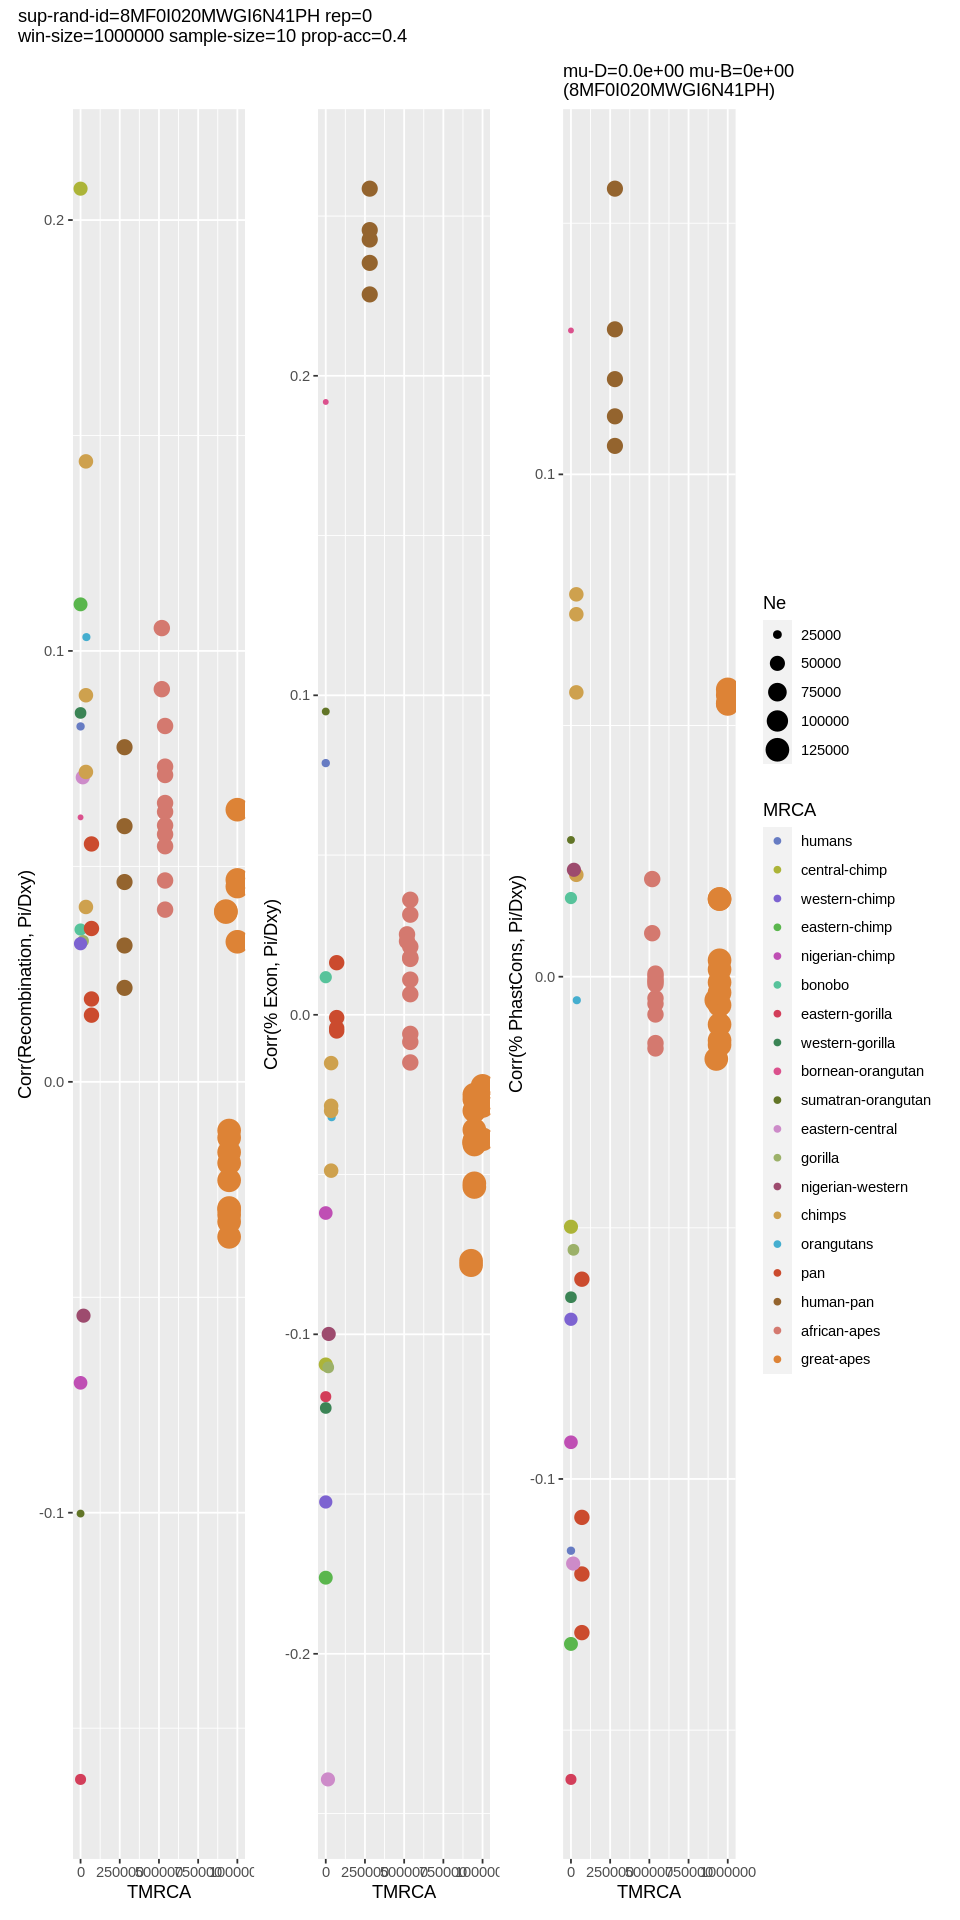

In [103]:
plots[[2]] + theme(legend.position="none")

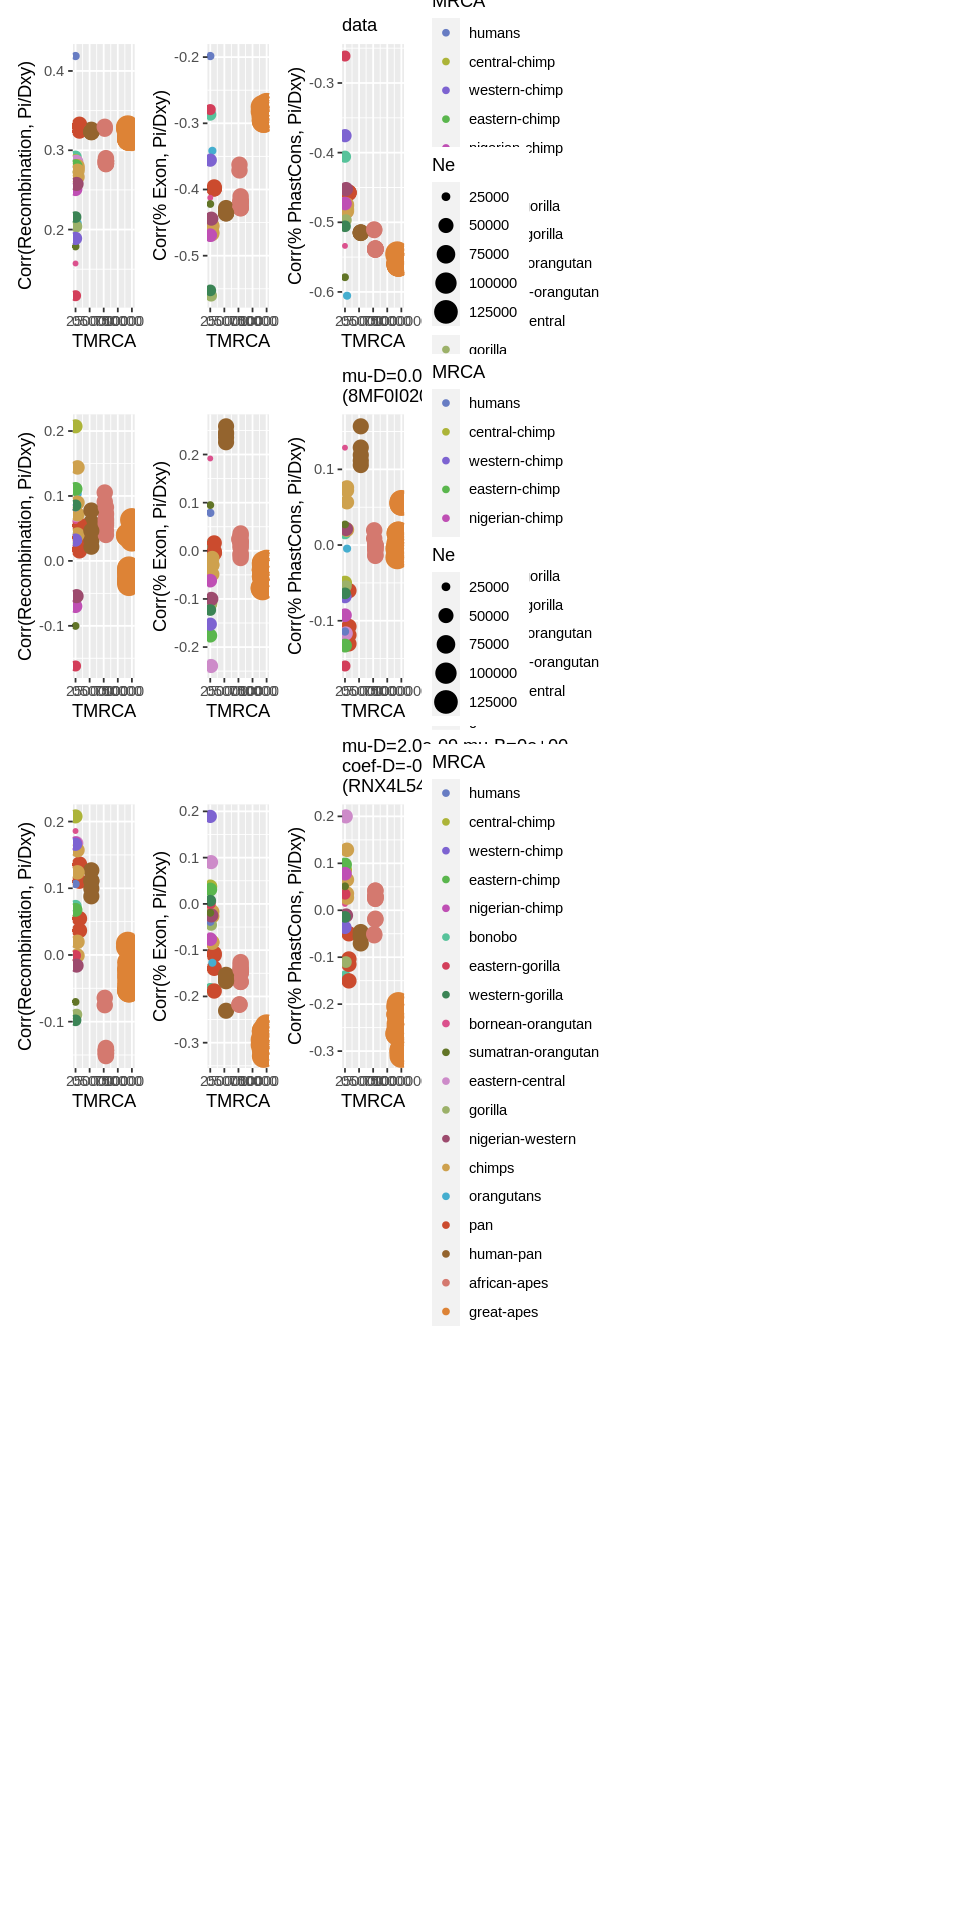

In [100]:
options(repr.plot.width=8, repr.plot.height=16)

wrap_plots(plots, design=areas, guides="collect")

In [35]:
for (fig_prefix in fig_prefixes) {
    plots = apply(tmp,1,
                  function(x) readRDS(paste0(x["folderpath"],
                                             "/",fig_prefix, "_",x["desc"],".rds"))+labs(subtitle=x["seldesc"]))

    data_path = paste0("../../output/greatapes-diversity-data/",fig_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_prop-acc_",prop_acc, ".rds")
    plots=c(list(readRDS(data_path)+labs(subtitle="data")), plots)

    panel_plot = wrap_plots(plots, nrow=length(classes), design=areas, guides="collect")

    wstr = paste0('win-size_',as.integer(win_size))
    plots_folder_path = paste0("../../output/data_and_sims/", wstr,"/pdf")

    dname = paste0(plots_folder_path)
    if(! dir.exists(dname))
            dir.create(dname, recursive=TRUE)


    panel_fname = paste0(plots_folder_path,"/",fig_prefix, "_","panel_sims_and_data_win-size_.pdf")

    panel_pngname = gsub("pdf", "png", panel_fname)


    ggsave(filename=panel_fname, plot=panel_plot, width=100, height=25, scale=1.75, units="cm", limitsize=FALSE)

    pdf_convert(panel_fname, dpi=160, filenames = panel_pngname)
}

Converting page 1 to ../../output/data_and_sims/win-size_1000000/png/annot-correls-tmrca_panel_sims_and_data_win-size_.png... done!


In [26]:
tmp

win_size,sup_rand_id,rep,sample_size,spaced_desc,desc,prop,is_ga_data,sigma,folderpath,⋯,posrate,poscoef,mu,poscoefdecayeps,rescf,win_len,padding,chr,selregime,seldesc
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,<chr>
1000000,8MF0I020MWGI6N41PH,0,10,sup-rand-id=8MF0I020MWGI6N41PH rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,0.0000e+00,0.000,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH)
1000000,RNX4L54J663QN2SY5X,0,10,sup-rand-id=RNX4L54J663QN2SY5X rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_RNX4L54J663QN2SY5X_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_RNX4L54J663QN2SY5X_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,2.0000e-09,0.000,1,-1,0,chr12,del_only,mu-D=2.0e-09 mu-B=0e+00 coef-D=-0.030 (RNX4L54J663QN2SY5X)
1000000,SIN0QA3J1CBIYBO7D7,0,10,sup-rand-id=SIN0QA3J1CBIYBO7D7 rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_SIN0QA3J1CBIYBO7D7_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_SIN0QA3J1CBIYBO7D7_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,2.0000e-09,0.000,1,-1,0,chr12,del_only,mu-D=2.0e-09 mu-B=0e+00 coef-D=-0.015 (SIN0QA3J1CBIYBO7D7)
1000000,UTJG9R531BVSR6UA41,0,10,sup-rand-id=UTJG9R531BVSR6UA41 rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_UTJG9R531BVSR6UA41_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_UTJG9R531BVSR6UA41_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,6.0000e-09,0.000,1,-1,0,chr12,del_only,mu-D=6.0e-09 mu-B=0e+00 coef-D=-0.030 (UTJG9R531BVSR6UA41)
1000000,O814WK8MN3UOF27JIR,0,10,sup-rand-id=O814WK8MN3UOF27JIR rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_O814WK8MN3UOF27JIR_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_O814WK8MN3UOF27JIR_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,6.0000e-09,0.000,1,-1,0,chr12,del_only,mu-D=6.0e-09 mu-B=0e+00 coef-D=-0.015 (O814WK8MN3UOF27JIR)
1000000,AA9GUSRHWOA341WGC4,0,10,sup-rand-id=AA9GUSRHWOA341WGC4 rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_AA9GUSRHWOA341WGC4_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_AA9GUSRHWOA341WGC4_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,1.2000e-08,0.000,1,-1,0,chr12,del_only,mu-D=1.2e-08 mu-B=0e+00 coef-D=-0.030 (AA9GUSRHWOA341WGC4)
1000000,CR1UIIF8NRSPZ94LGF,0,10,sup-rand-id=CR1UIIF8NRSPZ94LGF rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_CR1UIIF8NRSPZ94LGF_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_CR1UIIF8NRSPZ94LGF_rep_0_win-size_1000000_sample-size_10,⋯,0e+00,0.00,1.4000e-08,0.000,1,-1,0,chr12,del_only,mu-D=1.4e-08 mu-B=0e+00 coef-D=-0.030 (CR1UIIF8NRSPZ94LGF)
1000000,4GROMS6FHMNW5X9L72,0,10,sup-rand-id=4GROMS6FHMNW5X9L72 rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_4GROMS6FHMNW5X9L72_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_4GROMS6FHMNW5X9L72_rep_0_win-size_1000000_sample-size_10,⋯,1e-11,0.01,1.0000e-11,0.000,1,-1,0,chr12,pos_only,mu-D=0.0e+00 mu-B=1e-11 coef-B=0.01 decay-B=0.000 (4GROMS6FHMNW5X9L72)
1000000,HC27BSIEQBYZJHHUQV,0,10,sup-rand-id=HC27BSIEQBYZJHHUQV rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_HC27BSIEQBYZJHHUQV_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0.000,../../output/sims_results/sup-rand-id_HC27BSIEQBYZJHHUQV_rep_0_win-size_1000000_sample-size_10,⋯,1e-10,0.01,1.0000e-10,0.000,1,-1,0,chr12,pos_only,mu-D=0.0e+

In [27]:
fig_prefixes = c("subset-chr12-landscapes", "pairs-dxydxy", "pairs-pidxy", "pairs-pipi", "pairs-pidxy-colbyrec", "pairs-pidxy-colbyex")

In [28]:
for (fig_prefix in fig_prefixes) {
plots_folder_path = paste0("../../output/data_and_sims/", wstr)

dnames = paste0(plots_folder_path, c("/pdf", "/png"))
for (dname in dnames) {
    if(! dir.exists(dname))
        dir.create(dname, recursive=TRUE)
}

data_path2 = paste0("../../output/greatapes-diversity-data/figs/",fig_prefix,"_win-size_",as.integer(win_size),"_merged-mask_True_prop-acc_",prop_acc, ".pdf")

plots_paths = apply(tmp,1,
              function(x) paste0(x["folderpath"],
                                         "/figs/",fig_prefix,"_",x["desc"],".pdf"))
tmp$newfname = gsub(" ", "_", tmp[,"seldesc"])
tmp$newfname = gsub("\n", "_", tmp[,"newfname"])

new_paths = apply(tmp,1,
                 function(x) paste0(plots_folder_path,"/pdf/",fig_prefix,"_",x["selregime"],"_", x['newfname'],".pdf"))

plots_folder_path

file.copy(plots_paths, new_paths)
file.copy(data_path2, paste0(plots_folder_path,"/pdf/",fig_prefix, "_","data.pdf"))
png_paths = gsub("pdf", "png", new_paths)
#for (i in 1:length(png_paths)) {
    #pdf_convert(new_paths[i], dpi=160, filenames = png_paths[i])
#}
}
    
